# Multi-Class Classification Model for Sign Language MNIST Using Python and Scikit-Learn
### David Lowe
### November 16, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Sign Language MNIST dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The original MNIST image dataset of handwritten digits is a popular benchmark for image-based machine learning methods. The Sign Language MNIST is presented here and follows the same CSV format with labels and pixel values in single rows to stimulate the community to develop more drop-in replacements. The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z, which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 instances) are approximately half the size of the standard MNIST but otherwise similar with a header row of the labels, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds.

ANALYSIS: The average performance of the machine learning algorithms achieved an accuracy benchmark of 96.38%. Two algorithms (Extra Trees and Random Forest) produced the top accuracy metrics after the first round of modeling. After a series of tuning trials, the Extra Trees model turned in an accuracy metric of 99.61%. When configured with the optimized parameters, the Extra Trees model processed the validation dataset with an accuracy score of 99.83%. When we applied the Extra Trees model to the previously unseen test dataset, we obtained an accuracy score of 83.49%, which pointed to a high variance error.

CONCLUSION: In this iteration, the Extra Trees model did not appear to be suitable for modeling this dataset. We should consider experimenting another algorithm with this dataset.

Dataset Used: Sign Language MNIST Data Set

Dataset ML Model: Multi-Class classification with numerical attributes

Dataset Reference: https://www.kaggle.com/datamunge/sign-language-mnist

One source of potential performance benchmarks: https://www.kaggle.com/datamunge/sign-language-mnist

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

In [8]:
# Set up the parent directory location for loading the dotenv files
# useColab = True
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = True
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [11]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-sign-language-mnist/sign_mnist_train.csv'
Xy_original = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_original.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0      3     107     118     127     134     139     143     146     150     153  ...       207       207       207       207       206   
1      6     155     157     156     156     156     157     156     158     158  ...        69       149       128        87        94   
2      2     187     188     188     187     187     186     187     188     187  ...       202       201       200       199       198   
3      2     211     211     212     212     211     210     211     210     210  ...       235       234       233       231       230   
4     13     164     167     170     172     176     179     180     184     185  ...        92       105       105       108       133   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0       206       206       204       203       202  
1       163       175       103       135       149  
2       199       198       195       194       195  
3       226       225       222       229       163  
4       163       157       163       164       179  

[5 rows x 785 columns]

In [12]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Data columns (total 785 columns):
 #   Column    Dtype
---  ------    -----
 0   label     int64
 1   pixel1    int64
 2   pixel2    int64
 3   pixel3    int64
 4   pixel4    int64
 5   pixel5    int64
 6   pixel6    int64
 7   pixel7    int64
 8   pixel8    int64
 9   pixel9    int64
 10  pixel10   int64
 11  pixel11   int64
 12  pixel12   int64
 13  pixel13   int64
 14  pixel14   int64
 15  pixel15   int64
 16  pixel16   int64
 17  pixel17   int64
 18  pixel18   int64
 19  pixel19   int64
 20  pixel20   int64
 21  pixel21   int64
 22  pixel22   int64
 23  pixel23   int64
 24  pixel24   int64
 25  pixel25   int64
 26  pixel26   int64
 27  pixel27   int64
 28  pixel28   int64
 29  pixel29   int64
 30  pixel30   int64
 31  pixel31   int64
 32  pixel32   int64
 33  pixel33   int64
 34  pixel34   int64
 35  pixel35   int64
 36  pixel36   int64
 37  pixel37   int64
 38  pixel38   int64
 39  pixel39   int64
 40  pix

In [13]:
Xy_original.describe()

label        pixel1        pixel2        pixel3        pixel4        pixel5        pixel6        pixel7        pixel8  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean      12.318813    145.419377    148.500273    151.247714    153.546531    156.210891    158.411255    160.472154    162.339683   
std        7.287552     41.358555     39.942152     39.056286     38.595247     37.111165     36.125579     35.016392     33.661998   
min        0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.000000    121.000000    126.000000    130.000000    133.000000    137.000000    140.000000    142.000000    144.000000   
50%       13.000000    150.000000    153.000000    156.000000    158.000000    160.000000    162.000000    164.000000    165.000000   
75%       19.000000    174.000000    176.000000    178.000000    179.000000    181.000000    182.000000    183.000000    184.000000   
max       24.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000   

             pixel9  ...      pixel775      pixel776      pixel777      pixel778      pixel779      pixel780      pixel781      pixel782  \
count  27455.000000  ...  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     163.954799  ...    141.104863    147.495611    153.325806    159.125332    161.969259    162.736696    162.906137    161.966454   
std       32.651607  ...     63.751194     65.512894     64.427412     63.708507     63.738316     63.444008     63.509210     63.298721   
min        0.000000  ...      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000   
25%      146.000000  ...     92.000000     96.000000    103.000000    112.000000    120.000000    125.000000    128.000000    128.000000   
50%      166.000000  ...    144.000000    162.000000    172.000000    180.000000    183.000000    184.000000    184.000000    182.000000   
75%      185.000000  ...    196.000000    202.000000    205.000000    207.000000    208.000000    207.000000    207.000000    206.000000   
max      255.000000  ...    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000   

           pixel783      pixel784  
count  27455.000000  27455.000000  
mean     161.137898    159.824731  
std       63.610415     64.396846  
min        0.000000      0.000000  
25%      128.000000    125.500000  
50%      182.000000    182.000000  
75%      204.000000    204.000000  
max      255.000000    255.000000  

[8 rows x 785 columns]

In [14]:
Xy_original.isnull().sum()

label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64

In [15]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [16]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'label': 'targetVar'})

### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [17]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = 1

In [18]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (27455, 785) X_original.shape: (27455, 784) y_original.shape: (27455,)


### 1.f) Set up the parameters for data visualization

In [19]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [20]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [21]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [22]:
X_original.head()

pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  pixel10  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0     107     118     127     134     139     143     146     150     153      156  ...       207       207       207       207       206   
1     155     157     156     156     156     157     156     158     158      157  ...        69       149       128        87        94   
2     187     188     188     187     187     186     187     188     187      186  ...       202       201       200       199       198   
3     211     211     212     212     211     210     211     210     210      211  ...       235       234       233       231       230   
4     164     167     170     172     176     179     180     184     185      186  ...        92       105       105       108       133   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0       206       206       204       203       202  
1       163       175       103       135       149  
2       199       198       195       194       195  
3       226       225       222       229       163  
4       163       157       163       164       179  

[5 rows x 784 columns]

#### 2.a.ii) Dimensions and attribute types

In [23]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Data columns (total 784 columns):
 #   Column    Dtype
---  ------    -----
 0   pixel1    int64
 1   pixel2    int64
 2   pixel3    int64
 3   pixel4    int64
 4   pixel5    int64
 5   pixel6    int64
 6   pixel7    int64
 7   pixel8    int64
 8   pixel9    int64
 9   pixel10   int64
 10  pixel11   int64
 11  pixel12   int64
 12  pixel13   int64
 13  pixel14   int64
 14  pixel15   int64
 15  pixel16   int64
 16  pixel17   int64
 17  pixel18   int64
 18  pixel19   int64
 19  pixel20   int64
 20  pixel21   int64
 21  pixel22   int64
 22  pixel23   int64
 23  pixel24   int64
 24  pixel25   int64
 25  pixel26   int64
 26  pixel27   int64
 27  pixel28   int64
 28  pixel29   int64
 29  pixel30   int64
 30  pixel31   int64
 31  pixel32   int64
 32  pixel33   int64
 33  pixel34   int64
 34  pixel35   int64
 35  pixel36   int64
 36  pixel37   int64
 37  pixel38   int64
 38  pixel39   int64
 39  pixel40   int64
 40  pix

#### 2.a.iii) Statistical summary of the attributes

In [24]:
X_original.describe()

pixel1        pixel2        pixel3        pixel4        pixel5        pixel6        pixel7        pixel8        pixel9  \
count  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     145.419377    148.500273    151.247714    153.546531    156.210891    158.411255    160.472154    162.339683    163.954799   
std       41.358555     39.942152     39.056286     38.595247     37.111165     36.125579     35.016392     33.661998     32.651607   
min        0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000   
25%      121.000000    126.000000    130.000000    133.000000    137.000000    140.000000    142.000000    144.000000    146.000000   
50%      150.000000    153.000000    156.000000    158.000000    160.000000    162.000000    164.000000    165.000000    166.000000   
75%      174.000000    176.000000    178.000000    179.000000    181.000000    182.000000    183.000000    184.000000    185.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000   

            pixel10  ...      pixel775      pixel776      pixel777      pixel778      pixel779      pixel780      pixel781      pixel782  \
count  27455.000000  ...  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000  27455.000000   
mean     165.533673  ...    141.104863    147.495611    153.325806    159.125332    161.969259    162.736696    162.906137    161.966454   
std       31.279244  ...     63.751194     65.512894     64.427412     63.708507     63.738316     63.444008     63.509210     63.298721   
min        0.000000  ...      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000   
25%      148.000000  ...     92.000000     96.000000    103.000000    112.000000    120.000000    125.000000    128.000000    128.000000   
50%      167.000000  ...    144.000000    162.000000    172.000000    180.000000    183.000000    184.000000    184.000000    182.000000   
75%      186.000000  ...    196.000000    202.000000    205.000000    207.000000    208.000000    207.000000    207.000000    206.000000   
max      255.000000  ...    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000    255.000000   

           pixel783      pixel784  
count  27455.000000  27455.000000  
mean     161.137898    159.824731  
std       63.610415     64.396846  
min        0.000000      0.000000  
25%      128.000000    125.500000  
50%      182.000000    182.000000  
75%      204.000000    204.000000  
max      255.000000    255.000000  

[8 rows x 784 columns]

#### 2.a.iv) Summarize the levels of the class attribute

In [25]:
Xy_original.groupby('targetVar').size()

targetVar
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
dtype: int64

### 2.b) Data Visualization

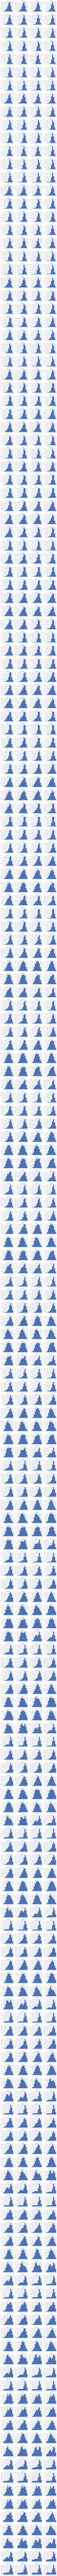

In [26]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

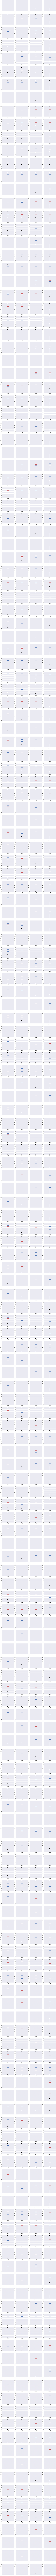

In [27]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

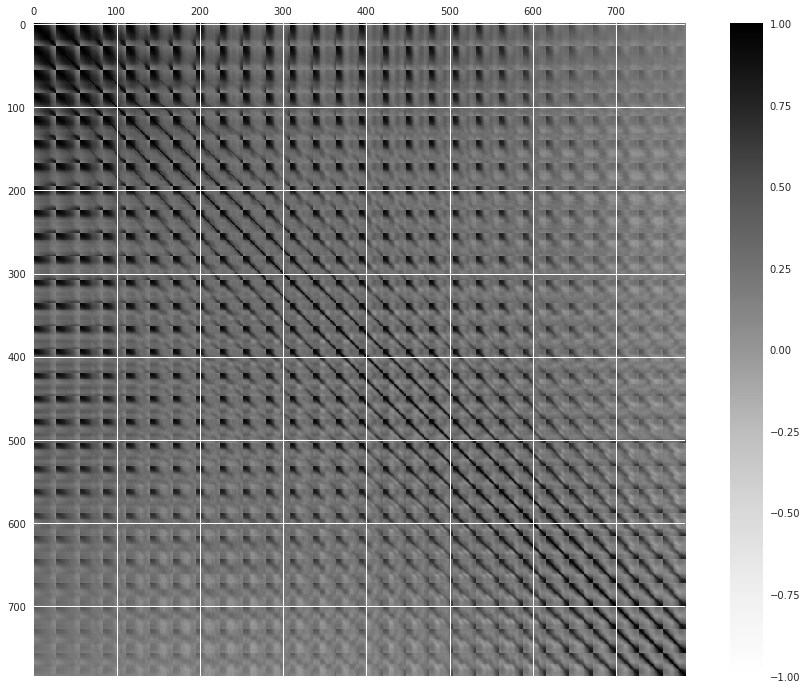

In [28]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [29]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [30]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [31]:
# Split the data further into training and validation datasets
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_original, y_original, test_size=val_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))

X_train_df.shape: (20591, 784) y_train_df.shape: (20591,)
X_validation_df.shape: (6864, 784) y_validation_df.shape: (6864,)


### 3.b) Feature Scaling and Data Pre-Processing

In [33]:
# Apply feature scaling and transformation
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'int'].tolist()
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
print(X_train_df.head())

Columns to scale are: ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pixel63', 'pixel64', 'pixel65', 'pixel66', 'pixel67', 'pixel68', 'pixel69', 'pixel70', 'pixel71', 'pixel72', 'pixel73', 'pixel74', 'pixel75', 'pixel76', 'pixel77', 'pixel78', 'pixel79', 'pixel80', 'pixel81', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel86', 'pixel87', 'pixel88', 'pixel89', 'pixel9

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


         pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7    pixel8    pixel9   pixel10  ...  pixel775  pixel776  \
14204  0.687077  0.659519  0.654681  0.628471  0.635513  0.620686  0.553037  0.549104  0.517285  0.489673  ...  1.194075  1.095422   
19315  0.614704  0.559445  0.501567  0.448431  0.421781  0.373088  0.325997  0.283760  0.243629  0.204057  ... -0.875268 -1.302054   
9314   0.759449  0.759592  0.731238  0.679911  0.662229  0.620686  0.581417  0.549104  0.517285  0.489673  ... -0.734176 -0.874479   
20570 -0.229642 -0.266163 -0.315045 -0.348890 -0.433149 -0.479750 -0.525403 -0.571240 -0.607745 -0.716263  ... -2.207799 -1.867064   
23966 -0.639753 -0.591402 -0.570236 -0.554650 -0.566732 -0.589793 -0.582163 -0.600723 -0.607745 -0.652792  ...  0.190757  0.591494   

       pixel777  pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
14204  1.021090  0.940411  0.878424  0.869080  0.863864  0.882087  0.873285  0.883140  
19315 -0.762573  0.

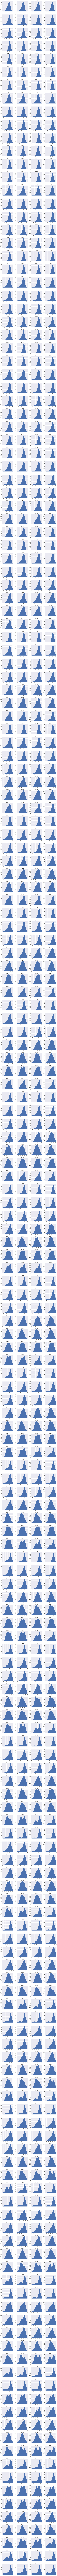

In [34]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [35]:
# Apply feature scaling and transformation to the validation dataset
scaled_features = scaler.transform(X_validation_df[columns_to_scale])
X_validation_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_validation_df.head())

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


         pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7    pixel8    pixel9   pixel10  ...  pixel775  pixel776  \
9810  -0.760373 -0.741513 -0.697831 -0.631810 -0.593448 -0.534771 -0.610543 -0.630206 -0.607745 -0.621057  ... -1.392604  1.003799   
21941 -0.229642 -0.291181 -0.340564 -0.323170 -0.352999 -0.397217 -0.440263 -0.512275 -0.486120 -0.525852  ... -0.796884  0.072295   
17847 -0.374387 -0.441292 -0.468159 -0.477490 -0.540015 -0.562282 -0.582163 -0.630206 -0.698963 -0.747998  ...  0.128050  0.225001   
21970 -0.977491 -2.267637 -1.157175 -0.940451 -2.383457 -3.946121 -3.335023 -2.723482 -2.736180 -2.810782  ... -0.185487 -0.233116   
3586  -0.302014 -0.266163 -0.187449 -0.091690 -0.059117 -0.012065  0.013817  0.047897  0.061192  0.140587  ... -0.075749 -0.767585   

       pixel777  pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
9810   0.648847  0.595401  0.533445  0.506587  0.454719  0.454894  0.448903  0.448334  
21941  0.431705  0.

### 3.c) Training Data Balancing

In [36]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [37]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [38]:
# Finalize the training and validation datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.ravel()
X_validation = X_validation_df.to_numpy()
y_validation = y_validation_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (20591, 784) y_train.shape: (20591,)
X_validation.shape: (6864, 784) y_validation.shape: (6864,)


In [39]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [40]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [41]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LDA', LinearDiscriminantAnalysis()))
train_models.append(('CART', DecisionTreeClassifier(random_state=seedNum)))
train_models.append(('KNN', KNeighborsClassifier(n_jobs=n_jobs)))
train_models.append(('BGT', BaggingClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('RNF', RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)))
train_models.append(('EXT', ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)))

In [42]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   14.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LDA: 0.990141 (0.002035)
LinearDiscriminantAnalysis()
Model training time: 0:00:14.794127 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   36.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


CART: 0.848624 (0.005334)
DecisionTreeClassifier(random_state=888)
Model training time: 0:00:36.904367 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.2min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KNN: 0.988053 (0.001982)
KNeighborsClassifier(n_jobs=2)
Model training time: 0:02:10.108243 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


BGT: 0.966102 (0.002819)
BaggingClassifier(n_jobs=2, random_state=888)
Model training time: 0:02:04.831001 



[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   50.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


RNF: 0.994561 (0.000954)
RandomForestClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:50.652678 

EXT: 0.995775 (0.000792)
ExtraTreesClassifier(n_jobs=2, random_state=888)
Model training time: 0:00:21.501344 

Average metrics (accuracy) from all models: 0.9638758371977462
Total training time for all models: 0:06:18.898987


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   21.4s finished


### 4.b) Spot-checking baseline algorithms

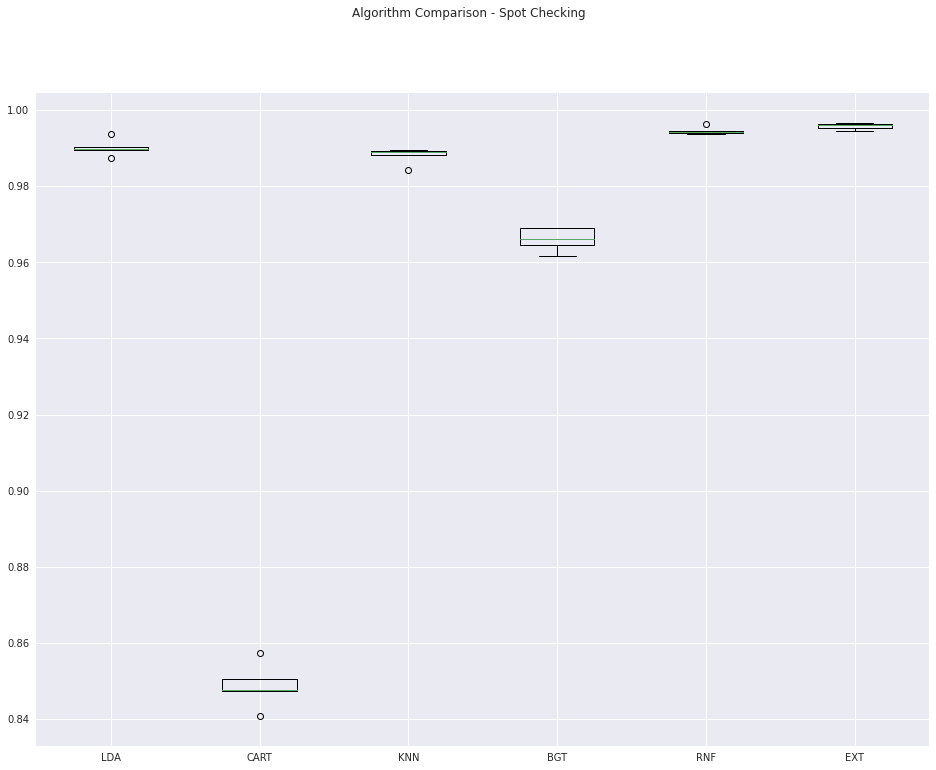

In [43]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [44]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [45]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [46]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [47]:
# Tuning algorithm #1 - Extra Trees
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = ExtraTreesClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('EXT')
paramGrid1 = dict(n_estimators=np.array([100, 200, 300, 400, 500]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  4.5min finished


Best: 0.996843 using {'n_estimators': 500}
0.995775 (0.000792) with: {'n_estimators': 100}
0.996358 (0.001007) with: {'n_estimators': 200}
0.996649 (0.000471) with: {'n_estimators': 300}
0.996746 (0.000697) with: {'n_estimators': 400}
0.996843 (0.000752) with: {'n_estimators': 500}
Model training time: 0:05:08.781074


In [48]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 500


In [49]:
# Tuning algorithm #2 - Random Forest
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = RandomForestClassifier(random_state=seedNum, n_jobs=n_jobs)
tune_model_names.append('RNF')
paramGrid2 = dict(n_estimators=np.array([100, 200, 300, 400, 500]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed: 10.7min finished


Best: 0.996115 using {'n_estimators': 400}
0.994561 (0.000954) with: {'n_estimators': 100}
0.995144 (0.000827) with: {'n_estimators': 200}
0.995435 (0.000976) with: {'n_estimators': 300}
0.996115 (0.000594) with: {'n_estimators': 400}
0.996066 (0.000710) with: {'n_estimators': 500}
Model training time: 0:12:01.765355


In [50]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 400


### 5.b) Compare Algorithms After Tuning

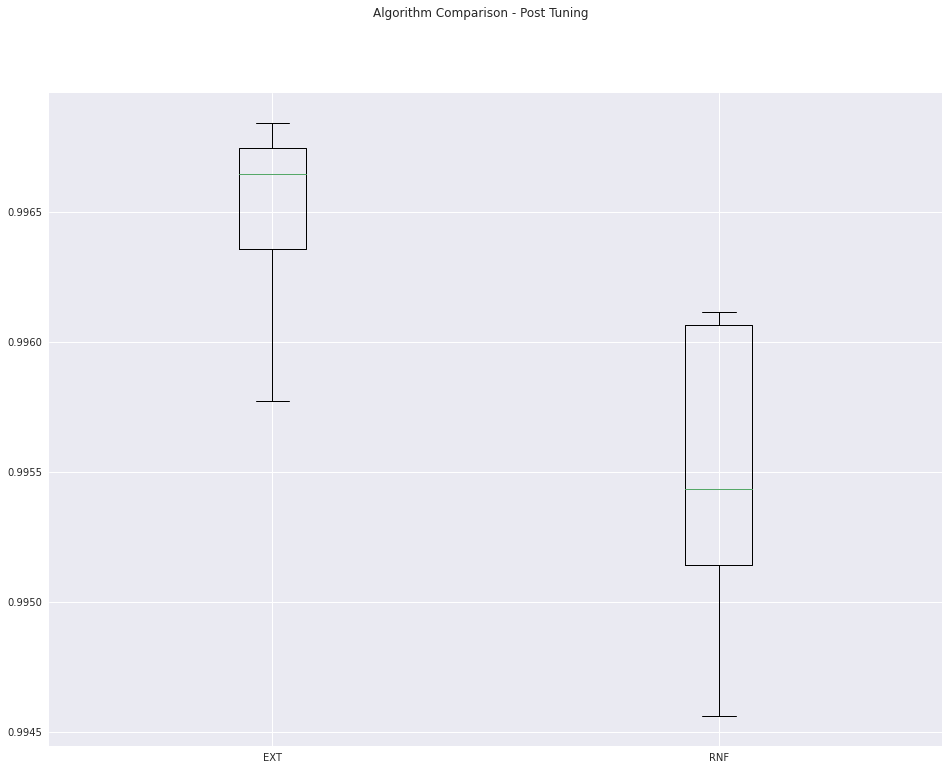

In [51]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [52]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [53]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Validate the models using the validation dataset

In [54]:
validation_model1 = ExtraTreesClassifier(n_estimators=best_paramValue1, random_state=seedNum, n_jobs=n_jobs)
validation_model1.fit(X_train, y_train)
print(validation_model1)
predictions1 = validation_model1.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions1))
print(confusion_matrix(y_validation, predictions1))
print(classification_report(y_validation, predictions1))

ExtraTreesClassifier(n_estimators=500, n_jobs=2, random_state=888)
Accuracy Score: 0.9983974358974359
[[282   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 252   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 286   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 299   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 239   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 301   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 272   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 253   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 289   0   0   0   1   0   1   0   0   0
    0   0   0   

In [55]:
validation_model2 = RandomForestClassifier(n_estimators=best_paramValue2, random_state=seedNum, n_jobs=n_jobs)
validation_model2.fit(X_train, y_train)
print(validation_model2)
predictions2 = validation_model2.predict(X_validation)
print('Accuracy Score:', accuracy_score(y_validation, predictions2))
print(confusion_matrix(y_validation, predictions2))
print(classification_report(y_validation, predictions2))

RandomForestClassifier(n_estimators=400, n_jobs=2, random_state=888)
Accuracy Score: 0.9978146853146853
[[282   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 252   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 286   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 298   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0]
 [  0   0   0   0 239   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 301   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 272   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 253   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 290   0   0   0   0   0   1   0   0   0
    0   0   0 

### 6.b) Create a test model using all available data

In [56]:
# Combining the training and validation datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_validation))
y_complete = np.concatenate((y_train, y_validation))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
test_model = validation_model1.fit(X_complete, y_complete)
print(test_model)

X_complete.shape: (27455, 784) y_complete.shape: (27455,)
ExtraTreesClassifier(n_estimators=500, n_jobs=2, random_state=888)


### 6.c) Load test dataset and measure predictions

In [57]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-sign-language-mnist/sign_mnist_test.csv'
Xy_test = pd.read_csv(dataset_path, sep=',')

# Take a peek at the dataframe after import
Xy_test.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  \
0      6     149     149     150     150     150     151     151     150     151  ...       138       148       127        89        82   
1      5     126     128     131     132     133     134     135     135     136  ...        47       104       194       183       186   
2     10      85      88      92      96     105     123     135     143     147  ...        68       166       242       227       230   
3      0     203     205     207     206     207     209     210     209     210  ...       154       248       247       248       253   
4      3     188     191     193     195     199     201     202     203     203  ...        26        40        64        48        29   

   pixel780  pixel781  pixel782  pixel783  pixel784  
0        96       106       112       120       107  
1       184       184       184       182       180  
2       227       226       225       224       222  
3       236       230       240       253       255  
4        46        49        46        46        53  

[5 rows x 785 columns]

In [58]:
# Standardize the class column to the name of targetVar if required
Xy_test = Xy_test.rename(columns={'label': 'targetVar'})

In [59]:
X_test_df = Xy_test.iloc[:,1:totCol]
y_test_df = Xy_test.iloc[:,0]
print("Xy_test.shape: {} X_test_df.shape: {} y_test_df.shape: {}".format(Xy_test.shape, X_test_df.shape, y_test_df.shape))

Xy_test.shape: (7172, 785) X_test_df.shape: (7172, 784) y_test_df.shape: (7172,)


In [60]:
# Apply feature scaling and transformation to the test dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


     pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7    pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  \
0  0.083972  0.009040 -0.034334 -0.091690 -0.165984 -0.204641 -0.269983 -0.364861 -0.394901 -0.430646  ... -0.044395  0.011213 -0.405840   
1 -0.470883 -0.516347 -0.519197 -0.554650 -0.620165 -0.672326 -0.724063 -0.807103 -0.850995 -0.874938  ... -1.470988 -0.660691  0.633337   
2 -1.459974 -1.517084 -1.514442 -1.480571 -1.368228 -0.974945 -0.724063 -0.571240 -0.516526 -0.430646  ... -1.141774  0.286083  1.377822   
3  1.386677  1.410071  1.420254  1.348632  1.356860  1.390990  1.404437  1.374622  1.399065  1.378257  ...  0.206434  1.538268  1.455373   
4  1.024815  1.059813  1.062987  1.065712  1.143127  1.170903  1.177397  1.197725  1.186222  1.187846  ... -1.800201 -1.638006 -1.382977   

   pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
0 -1.098285 -1.254178 -1.053709 -0.898606 -0.795042 -0.651346 -0.825028  
1  0.375849

In [61]:
# Finalize the test dataset for the modeling testing
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (7172, 784) y_test.shape: (7172,)


In [62]:
test_predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

Accuracy Score: 0.8349135527049637
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 404   0   2   0   0   0   0   0  26   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 309   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 244   0   0   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0]
 [  0   0   0   0 490   0   0   0   0   0   0   1   0   0   0   0   0   7
    0   0   0   0   0   0]
 [  0   0  16   0   0 226   0   0   0   0   2   0   0   0   0   0   0   0
    3   0   0   0   0   0]
 [  0   0   0   0   0   0 302   1   0   0   0   0   0   0   2   0   0   0
   43   0   0   0   0   0]
 [  0   0   0   0   0   0  19 413   0   0   0   0   0   0   0   0   0   0
    4   0   0   0   0   0]
 [  3   0   0   0   0   0   0   0 234   0   0   6   3   0   0   0   0  21
    2   0   0   0   0  19]
 [  0   0   0   5   0   0   0   0  13 238   1   0   0   

In [63]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [64]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:36:15.140354
